# Homework 5: Mixing Processes and Southern Ocean #

## 1) Write a program to simulate an ensemble of random walking particles.

### A) Compute the RMS distance from the initial positition as a function of time.

The steps in your program should be something like this

1. Create an ensemble of particles which all have the same initial position.
1. Loop over $N$ time steps:
  1. Assign a random angle to each particle
  1. Displace each particle by a fixed distance $\Delta x$ in the random direction
  1. Calculate the RMS distance $\overline{r^2}$ from the initial position  
1. Plot $\overline{r^2}$ as a function of time

### B) Calculate the diffusivity $K = \frac{1}{2} \frac{d}{dt} \overline{r^2}$

### C) How does the diffusivity depend on the amplitude of the displacement $\Delta x$ at each timestep?

You may answer this question directly through mathematical analysis or empirically through simulation. In either case, you should come up with a quantitative law relating $K$ and $\Delta x$.

## 2) Download GDP data and use it to calculate diffusivity.

In analogy with the previous problem, here you will calculate diffusivity based on the spreading of an ensemble of _real_ drifters from the global drifter program.

In cartesian geometry, the second moment of an ensemble of particles can be defined as the mean squared distance from the ensemble-mean position (center of mass), i.e.

$$
\overline{r^2} = \overline{ (x - \overline{x})^2} + \overline{(y - \overline{y})^2 }
$$

where the overbar indicates an average over all the particles. The Lagrangian diffusivity is given by

$$
K = \frac{1}{2} \frac{d}{dt} \overline{r^2} \ .
$$

On the spherical Earth, we need to modify the formula to calculate the distance correctly. Distances on Earth are given by the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula). Fortunately the Gibbs Sea Water toolkit implements this formulat for us in the function ``gsw.earth.distance``.  For longitude ($\gamma$) and latitude ($\varphi$), the second moment becomes, in pseudocode,

$$
\overline{r^2} = \overline{ {\tt distance}( [\overline{\gamma}, \gamma], [\overline{\varphi}, \varphi])^2 } \ .
$$


Download the following data file and load it as an [xray](http://xray.readthedocs.org) dataset. (If you can't run ``curl``, simply paste the link into your browser and save the file to the directory from which you are running this notebook.)

In [1]:
! curl -O ftp://ftp.ldeo.columbia.edu/pub/rpa/EESCW4925/sample_float_data.nc
import xray
ds = xray.open_dataset('sample_float_data.nc')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62163  100 62163    0     0  97819      0 --:--:-- --:--:-- --:--:-- 97740


### A) Describe the dataset properties. What are the dimensions? How many floats are there? How long does the record last?

In [2]:
ds

<xray.Dataset>
Dimensions:   (float_id: 14, time: 239)
Coordinates:
  * float_id  (float_id) int64 7700452 7700486 7701866 7712321 7712323 ...
  * time      (time) float64 0.0 1.44e+04 2.88e+04 4.32e+04 5.76e+04 7.2e+04 ...
Data variables:
    lat       (time, float_id) float64 42.59 42.12 43.16 36.86 37.36 43.07 ...
    lon       (time, float_id) float64 316.9 316.0 319.3 316.6 320.4 318.1 ...
Attributes:
    time_units: seconds

In [3]:
print ds.time.max() / (24*60*60), 'days'

<xray.DataArray 'time' ()>
array(39.666666666666664) days


### B) Make a "spaghetti plot" of all the different float trajectories.
If you can, make this into an actual map using [basemap](http://matplotlib.org/basemap/). What part of the ocean are we in?

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import gsw
import xray
%matplotlib inline
import os

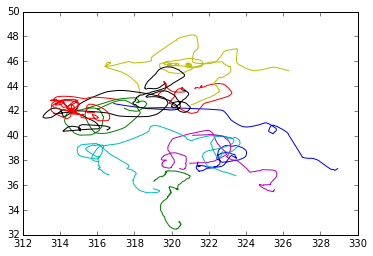

In [5]:
plt.plot(ds.lon, ds.lat);

### C) Plot the mean position of the ensemble (i.e. first moment, center of mass) as a function of time.

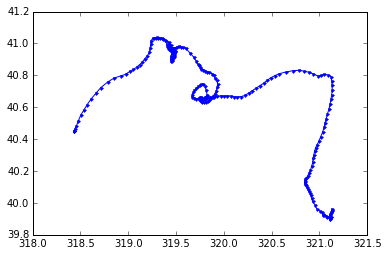

In [16]:
plt.plot(ds.lon.mean(dim='float_id'), ds.lat.mean(dim='float_id'), '.-')

### C) Calculate and plot (as a function of time) the second moment $\overline{r^2}$ of the ensemble.

In [17]:
# note: the straightforward way to do this is to just write lots of loops.
# The code I show here is more compact and sophisticated.

In [6]:
def distance_from(lon, lat, lon0, lat0):
    assert lon.shape == lat.shape
    dist = np.zeros_like(lon)
    it = np.nditer([lon, lat, dist],
            flags = ['buffered'],
            op_flags = [['readonly'],['readonly'],
                        ['writeonly', 'allocate', 'no_broadcast']])
    for x, y, d in it:
        d[...] = gsw.earth.distance([lon0, x],[lat0, y])
    return it.operands[-1]

In [7]:
def second_moment(ds):
    lon0 = ds.lon.mean(dim='float_id')
    lat0 = ds.lat.mean(dim='float_id')
    dist = distance_from(ds.lon, ds.lat, lon0, lat0)
    d2 = np.atleast_1d([(dist**2).mean()])
    t = np.atleast_1d(ds.time.data)
    da = xray.DataArray(d2, coords=[t], dims=['time'], name='dist_square')
    return da

In [8]:
dist_square = ds.groupby('time').apply(second_moment)

In [11]:
# linear fit
p = np.polyfit(dist_square.time, dist_square, 1)
p1d = np.poly1d(p)
# diffusivity
K = p[0] / 2
print 'Diffusivity:', K, 'm^2/s'

Diffusivity: 25156.4572649 m^2/s


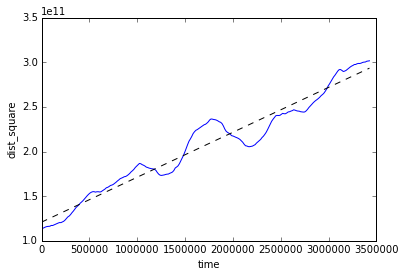

In [14]:
fig, ax = plt.subplots()
dist_square.plot(ax=ax)
ax.plot(dist_square.time, p1d(dist_square.time), 'k--')

## 3) Spreading of a Helium Plume

The figure below shows a section of $^3$He concentration near the East Pacific Rise. The spreading of the plume is indicative of the presence of vertical mixing.

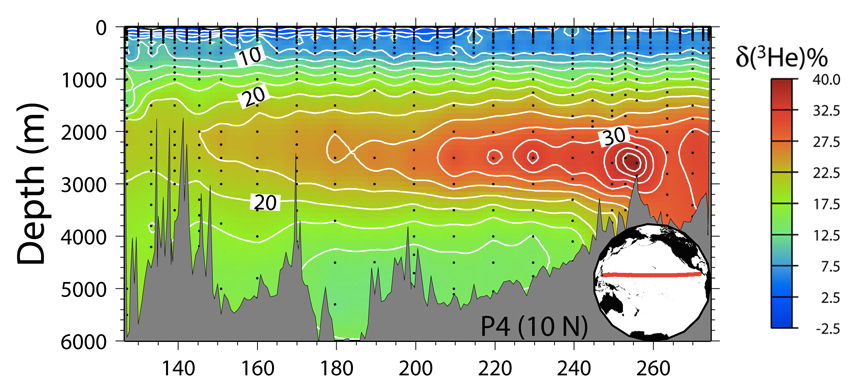

In [111]:
from IPython.display import Image
Image('plume.png')

Model the spreading of a plume emitted from a hydrothermal vent using the advection / diffusion equation we studied in class.

We assume that the $^3$He is emitted with an initial concentration described by:

$$
c(x=0, z) = \frac{C_0}{\sigma_0 \sqrt{2 \pi}} e^{-(z - z_0)^2 / 2 \sigma_0^2}
$$

where $z_0$ is the depth of the hydrothermal vent and\sigma_0$ represents the spread of the plume.

The plume is advected zonally (eastward) by a uniform background velocity $u$ and diffused vertically at with diffusivity $k_v$.

### A) Write an equation for the plume concentration c(x,z)

We know vertical diffusion will spread the plume vertically in time according to

$$ \sigma(t) = \sqrt{\sigma_0^2 + 2 k_v t} \ . $$

To translate this to a function in $x$, we realize that position in the $x$ direction corresponds to the time since passing the vent according to

$$
x = u t
$$

leading to

$$ \sigma(x) = \sqrt{\sigma_0^2 + 2 k_v x / u} \ . $$

Plugging this into the tracer equation gives

$$ c(x, z) = \frac{C_0}{\sigma(x) \sqrt{2 \pi}} e^{-(z - z_0)^2 / 2 \sigma(x)^2} \ . $$




### B) Plot your solution using the following paramters

Use a domain of x = 0 to 2000 km, z = -5000 m to 0.

$z_0 = -1000$ m

$\sigma_0 = 100$ m

$C_0 = 1$ (concentration is normalized)

$u = 0.1$ cm/s

$k_v = 2 \times 10^{-4}$ cm$^2$/s


In [2]:
def gaussian_profile(z, z0, c0, sigma):
    return (c0 / (sigma * np.sqrt(2*np.pi))) * (
        np.exp( -(z-z0)**2 / (2*sigma**2) )
    )

In [112]:
H = 5000
z = np.linspace(-H,0,200)[:,np.newaxis]
z00 = -2000
L = 1e6
x = np.linspace(0, L, 400)[np.newaxis,:]
c0 = 1
sigma0 = 100
u = 0.001
w = 2e-7
t = x/u
z0 = z00 + w*t
Kv = 2e-4
sigma = np.sqrt(sigma0**2 + 2*Kv*t)

c = gaussian_profile(z, z0, c0, sigma)


<matplotlib.contour.QuadContourSet instance at 0x1197936c8>

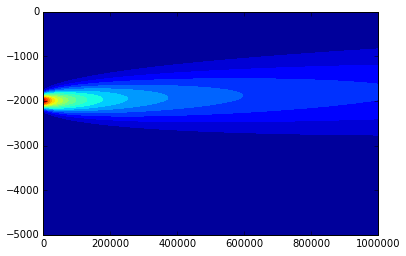

In [113]:
plt.contourf(x.squeeze(), z.squeeze(), c, 20)

## 2) Southern Ocean Eddy Diffusivity

In this problem, we will make a "back of the envelope" estimate of the eddy diffusivity in the Southern Ocean.

### A) Calculate the Ekman transport at 50S, assuming the wind stress to be 0.2 N m-2.

### B) Based on the temperature section below, plus your estimate from part 1, estimate the meridional heat transport at 50S due to the wind-driven circulation.
You may assume the surface Ekman transport is returned by a deep geostrophic flow below 2000 m. Arrive at an estimate in Watts by assuming this section is representative of the whole Southern Ocean. In what direction is heat being transported by the wind-driven circulation?

### C) Now refer to your air-sea interaction notes to find the net observed ocean meridional heat transport at 50S based on Earth's radiative balance. How does it compare with your estimate in part B?

### D) The difference is due to eddy transport. Estimate the strength of the eddy meridional heat transport at 50S.

### E) Assuming that eddies transfer heat meridionally in proportion to the meridional temperature gradient (i.e. $\overline{v'\theta'} = -K \partial \overline{\theta} / \partial y$ ), estimate $K$, the eddy transfer coefficient.

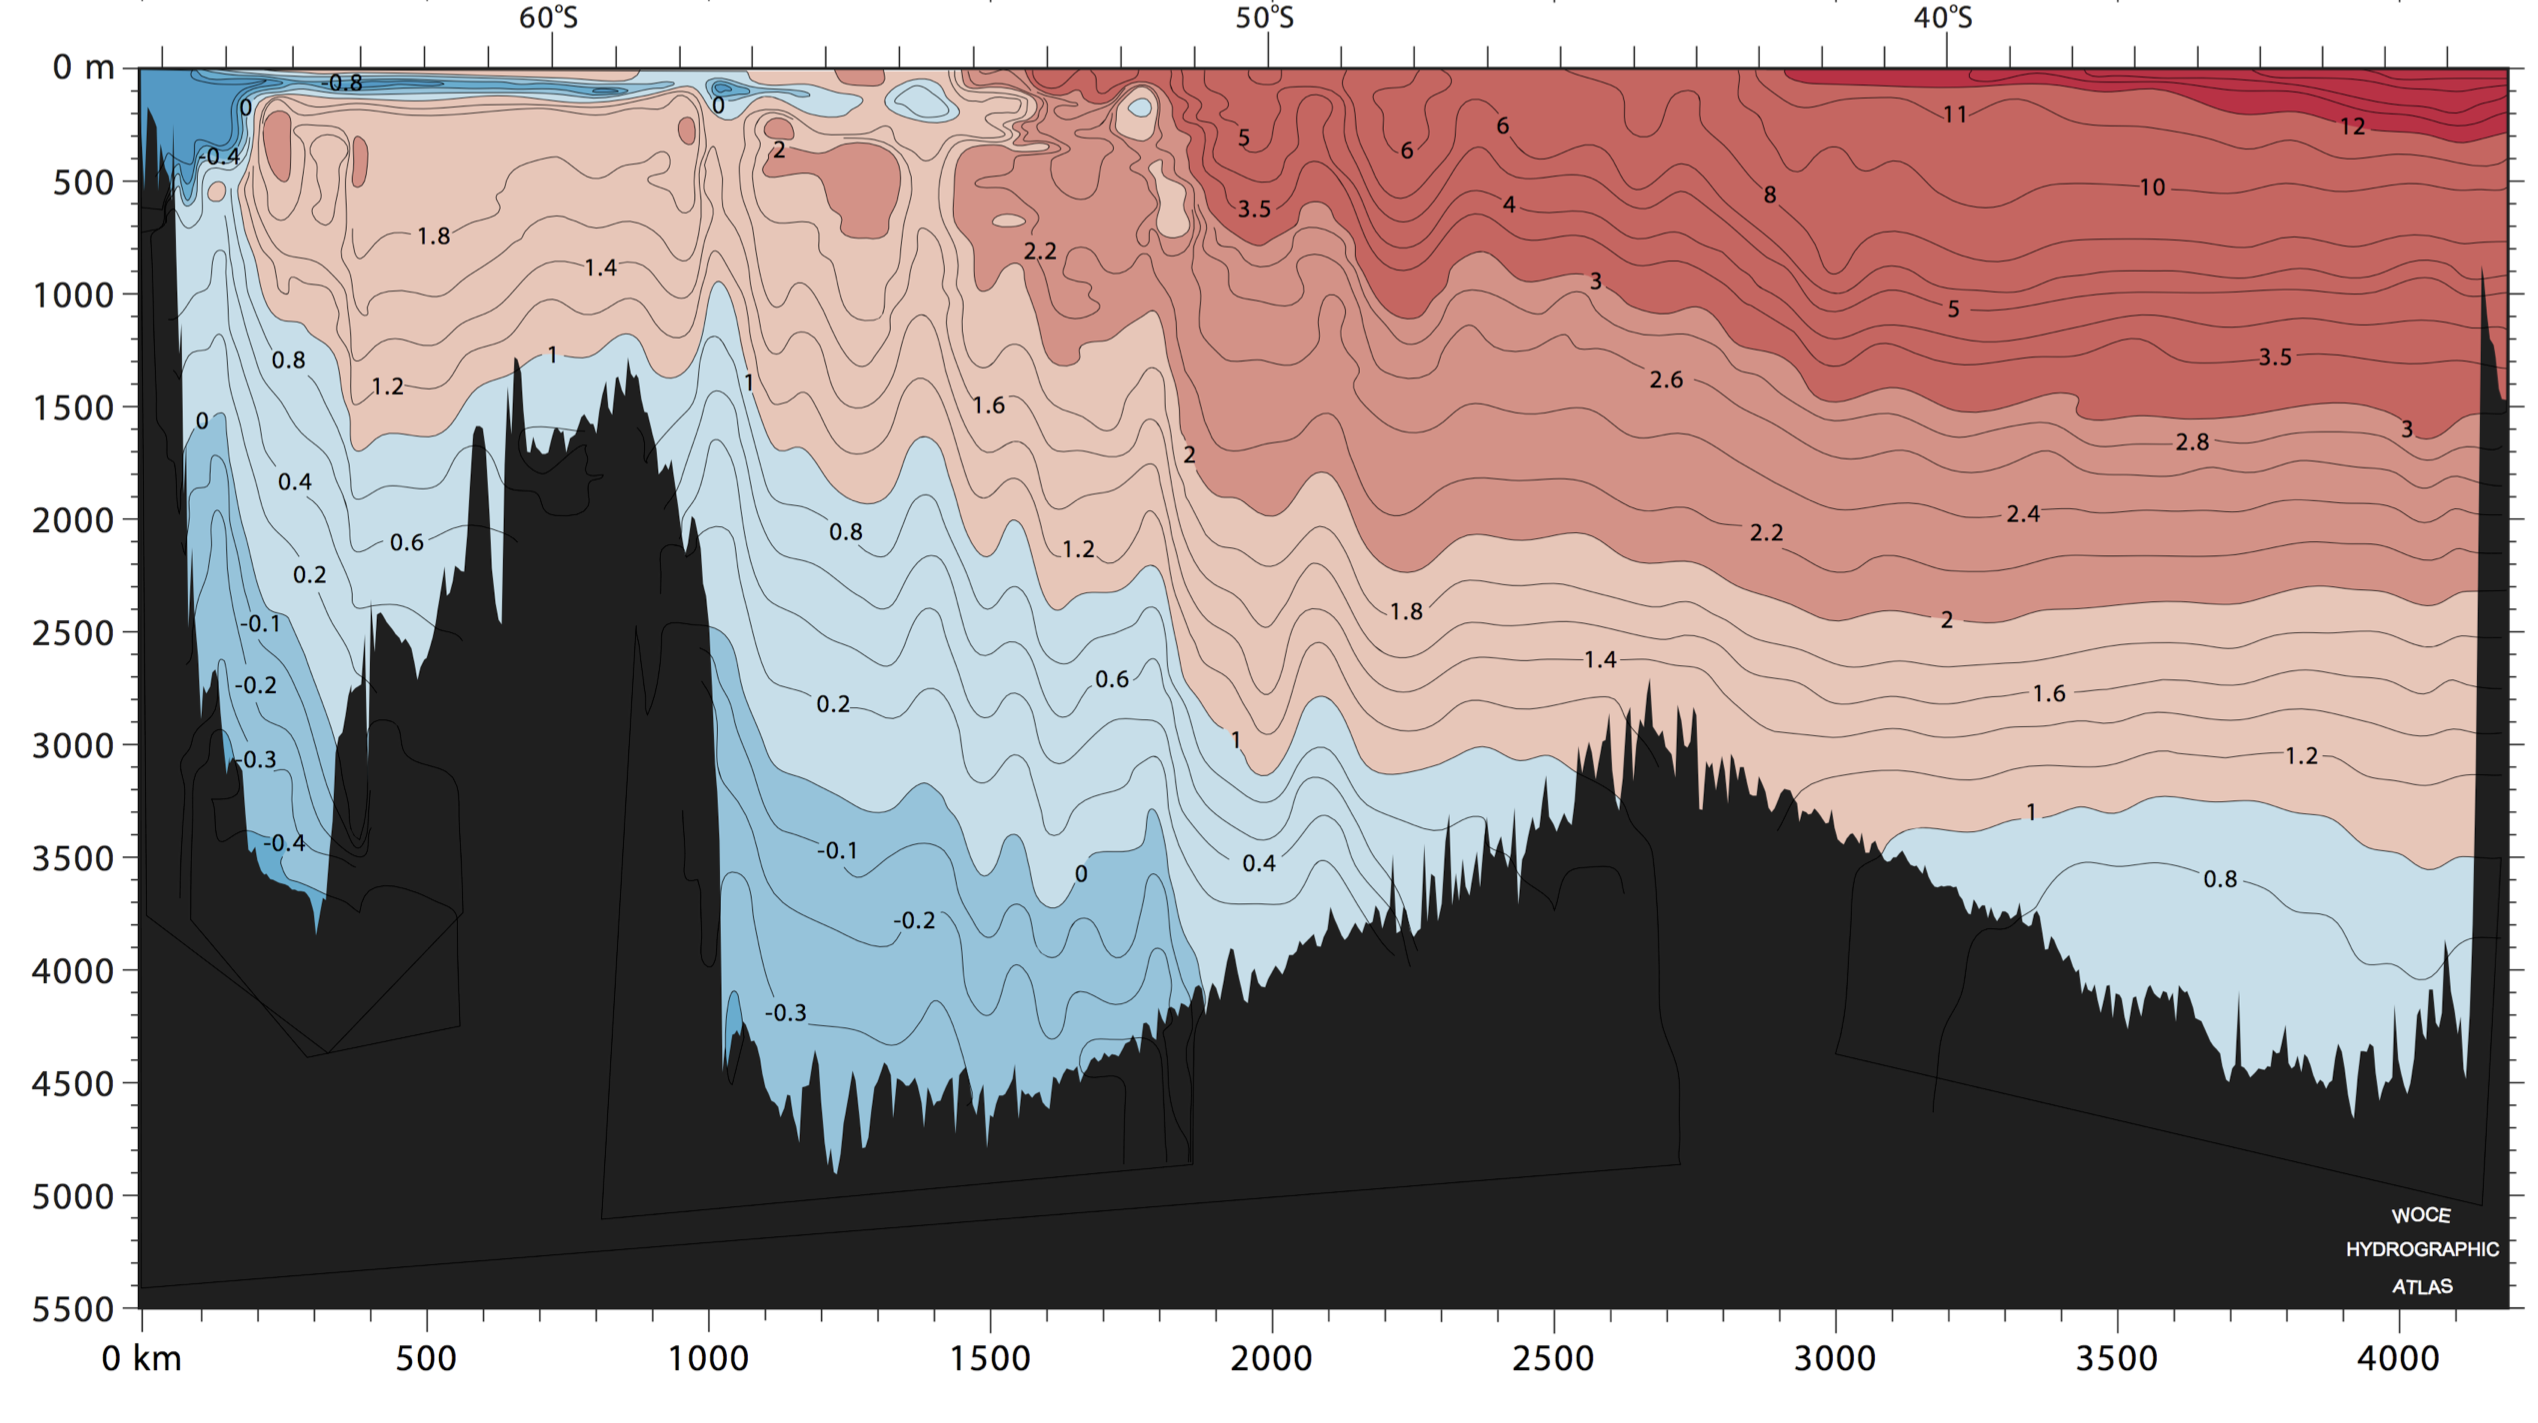

In [115]:
Image('SO_section.png')